# Visualization of different values of discriminative need

(For one meaning distribution)

## Configs

In [18]:
import os
import torch
import pandas as pd
import plotnine as pn

In [19]:
# Constants 

# example fn
"multirun/states=10/words=10/prior=-8/dist=squared_dist/meaning_certainty=-2/discr_need=-1/seed=42/dynamics=two_population_rd/num_trials=10/population_size=None/simulation_points.csv"

# standard configs
num_states = 10
num_signals = 10
prior = -8
distance = "squared_dist"
meaning_certainty = 0
seed = 42

discr_needs = torch.arange(-3, 4, 0.5).tolist() # swept values
# discr_needs = torch.arange(-3, -1, 0.5).tolist() # for 1000

# Replicator Dynamics specific configs
dynamics = "two_population_rd"
num_trials = 8
population_size = None

# # Nowak Krakauer specific configs
# dynamics = "nowak_krakauer"
# num_trials = 8
# population_size = 100

# # Moran process specific configs
# dynamics = "moran_process"
# num_trials = 8
# population_size = 100

## Load Data

In [20]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"

#############################################################################
# Analysis files
#############################################################################

curve_fn = f"multirun/states={num_states}/signals={num_signals}/prior={prior}/dist={distance}/meaning_certainty={meaning_certainty}/curve_points.csv"

ub_curve_fn = curve_fn.replace("curve_points", "ub_curve_points")

#############################################################################
# Simulation points
#############################################################################

sim_fns = {
    f"{discr_need}":
    f"multirun/states={num_states}/signals={num_signals}/prior={prior}/dist={distance}/meaning_certainty={meaning_certainty}/discr_need={discr_need}/seed={seed}/dynamics={dynamics}/num_trials={num_trials}/population_size={population_size}/simulation_points.csv"
    for discr_need in discr_needs
    }

ub_sim_fns = {key: value.replace("simulation_points", "ub_points") for key, value in sim_fns.items()}

In [21]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))
get_dfs_dict = lambda fns: {k: read(fns[k]) for k in fns}

curve_data = read(curve_fn)
ub_curve_data = read(ub_curve_fn)

sim_dfs = get_dfs_dict(sim_fns)
ub_sim_dfs = get_dfs_dict(ub_sim_fns)

# sim_dfs = {k: read(sim_fns[k]) for k in sim_fns}
# ub_sim_dfs = {k: read(ub_sim_fns[k]) for k in ub_sim_fns}

# curve_data = pd.read_csv(curve_fn)
# sim_dfs = {k: pd.read_csv(sim_fns[k]) for k in sim_fns}

## Configure aesthetics

In [22]:
# label each df to be concatenated with a columns
for key in sim_dfs:
    df = sim_dfs[key]
    df["discr_need"] = key
    # this too
    df = ub_sim_dfs[key]
    df["discr_need"] = key

sim_data = pd.concat(sim_dfs.values())
ub_sim_data = pd.concat(ub_sim_dfs.values())

In [23]:
sim_data["discr_need"] = sim_data["discr_need"].astype(float)
ub_sim_data["discr_need"] = ub_sim_data["discr_need"].astype(float)
# data = data.assign(
#     alpha=pd.Categorical(
#         data["discr_need"],
#         categories=[str(discr_need) for discr_need in discr_needs]
#     )
# )
sim_data # N.B.: nans are expected for 'round' column

,complexity,accuracy,discr_need
0,0.000204,0.000193,-3.0
1,0.000130,0.000124,-3.0
2,0.000000,0.000000,-3.0
3,0.000093,0.000089,-3.0
4,0.000203,0.000192,-3.0
...,...,...,...
3,1.517633,1.269161,3.5
4,1.526092,1.274349,3.5
5,1.520735,1.271133,3.5
6,1.520718,1.271123,3.5


## Plot

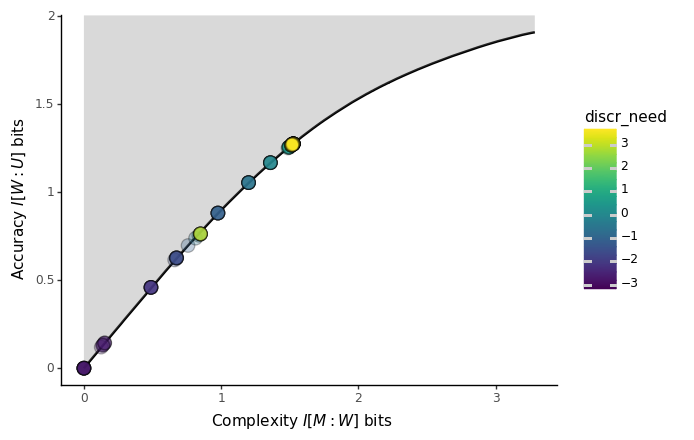

In [24]:
ib_plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_jitter( # emergent langs
        data=sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(ib_plot)

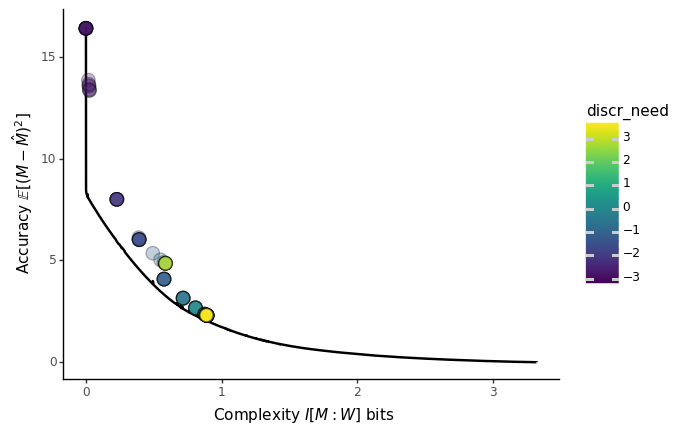

In [27]:
ub_plot = (
    # Set data and the axes
    pn.ggplot(
        data=ub_curve_data, mapping=pn.aes(x="complexity", y="mse")
    )  
    + pn.geom_line(size=1) # UB curve
    # + pn.geom_point(size=1)
    # + pn.geom_ribbon(
    # mapping=pn.aes(
    #     x="complexity",
    #     ymin="accuracy",
    #     ymax=torch.inf,
    #     ),
    #     fill="gray",
    #     alpha=0.3,
    # )
    + pn.geom_jitter( # emergent langs
        data=ub_sim_data,
        mapping=pn.aes(
            fill="discr_need",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Distortion $\mathbb{E}[(M - \hat{M})^2]$ ")
    + pn.theme_classic()
)
print(ub_plot)

In [26]:
# Uncomment to save!
# plot.save("10x10_game_two_pop_rd.png", width=10, height=10, dpi=300)